# Credit Card Fraud Classification
This data comes from Kaggle. It is simulated data. [link to dataset](https://www.kaggle.com/datasets/kelvinkelue/credit-card-fraud-prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date 

In [2]:
df = pd.read_csv('../../data/fraud_credit_card.csv')

## Feature Engineering 
Run the following code chunks in order, all only once

In [5]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [6]:
df.shape

(555719, 23)

In [7]:
df.is_fraud.sum()

2145

In [8]:
# percent of transactions NOT fraudulent
((555719-2145)/555719)*100

99.61401355721146

In [9]:
# drop unnecessary or redundant columns 
df = df.drop(columns=['Unnamed: 0', 'cc_num', 'first', 'last', 'trans_num', 'unix_time'])

# customerID, customer name ('first', 'last'), and transaction number should not influence whether the transaction 
# was a fraud. the transaction timestamp in unix format, `unix_time`, holds the same information as 
# trans_date_trans_time, thus trans_date_trans_time is redundant. 

#### Clean merchant name column

In [12]:
# determine that 'fraud' precedes the merchant name for every record, and remove 
val = 1
for m in df.merchant:
    if m[:5] != 'fraud':
        val *= 0
print('val =', val)

df['merchant'] = df['merchant'].apply(lambda x: x[6:])

val = 1


#### Encode gender variable

In [16]:
gender_map = {'F':0, 'M':1}
df['gender'] = df['gender'].map(gender_map)
df.rename(columns={'gender': 'is_male'}, inplace=True)

In [17]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud
0,21/06/2020 12:14,Kirlin and Sons,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,33.986391,-81.200714,0
1,21/06/2020 12:14,Sporer-Keebler,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,39.450498,-109.960431,0


#### Create Cardholder Age Column

In [22]:
# create an age feature from 'dob' then drop 'dob'
df['dob'] = pd.to_datetime(df['dob'], dayfirst=True)

# all transactions were made in 2020
df['cardholder_age'] = (2020 - df['dob'].dt.year)

In [23]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,cardholder_age
0,21/06/2020 12:14,Kirlin and Sons,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,33.986391,-81.200714,0,52
1,21/06/2020 12:14,Sporer-Keebler,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,39.450498,-109.960431,0,30


In [24]:
df = df.drop(['dob'], axis=1)

#### Date and Time

In [27]:
# create distinct time and date features 
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], dayfirst=True)
df['year'] = df['trans_date_trans_time'].dt.year
df['month'] = df['trans_date_trans_time'].dt.month
df['day'] = df['trans_date_trans_time'].dt.day
df['time'] = df['trans_date_trans_time'].dt.time
df['trans_dayOfWeek'] = df['trans_date_trans_time'].dt.day_name()

In [28]:
df.head(2)

,trans_date_trans_time,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,year,month,day,time,trans_dayOfWeek
0,2020-06-21 12:14:00,Kirlin and Sons,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,52,2020,6,21,12:14:00,Sunday
1,2020-06-21 12:14:00,Sporer-Keebler,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,30,2020,6,21,12:14:00,Sunday


In [29]:
df = df.drop(['trans_date_trans_time'], axis=1)

In [30]:
# round time feature to hour of the day then replace

# helper function
def hour_round(dt):
    h = dt.hour
    m = dt.minute
    if m>30:
        if h==23:
            return 0
        else:
            return h+1
    return h

df['hour_of_day'] = df['time'].apply(hour_round)

In [31]:
df.head(2)

,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,year,month,day,time,trans_dayOfWeek,hour_of_day
0,Kirlin and Sons,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,52,2020,6,21,12:14:00,Sunday,12
1,Sporer-Keebler,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,30,2020,6,21,12:14:00,Sunday,12


In [32]:
df = df.drop(['time'], axis=1)

In [34]:
# all transactions occur in 2020 over the last 7 months of the year
print('Unique years:', df['year'].unique())
print('Unique months:', df['month'].unique())

Unique years: [2020]
Unique months: [ 6  7  8  9 10 11 12]


In [35]:
# drop year column
df = df.drop(['year'], axis=1)

## Date and Time Information

#### Month

In [43]:
month_df = pd.DataFrame({'month':df.groupby('month').is_fraud.sum().index,
                         'num_fraud_transactions':df.groupby('month').is_fraud.sum().values,
                         'num_total_transactions':df.groupby('month').is_fraud.count().values},
                       )
month_df['fraud_likelihood'] = month_df['num_fraud_transactions'] / month_df['num_total_transactions']

In [46]:
month_df.head(2)

,month,num_fraud_transactions,num_total_transactions,fraud_likelihood
0,6,133,30058,0.004425
1,7,321,85848,0.003739


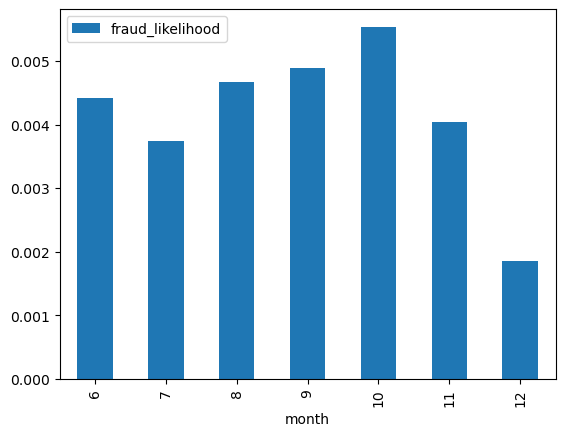

In [47]:
# observe the likelihood of fraudulent transactions by month
month_df.plot.bar(x='month', y='fraud_likelihood');

We can see above how the months had similar amounts of fraud relative to their total amount of transactions. It looks like december had the lowest likelihood but we would need to perform further analysis to see if this is a statistically significant difference. 

In [52]:
# add new information to the larger df
df = pd.merge(df, month_df[['month','fraud_likelihood']], how='left', on='month')

In [68]:
df.head(2)

,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,month,day,trans_dayOfWeek,hour_of_day,fraud_likelihood
0,Kirlin and Sons,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,52,6,21,Sunday,12,0.004425
1,Sporer-Keebler,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,30,6,21,Sunday,12,0.004425


In [70]:
# rename column
df.rename(columns={'fraud_likelihood': 'month_fraud_likelihood'}, inplace=True)

# remove job title
df = df.drop(['month'], axis=1)

#### Hour of the Day

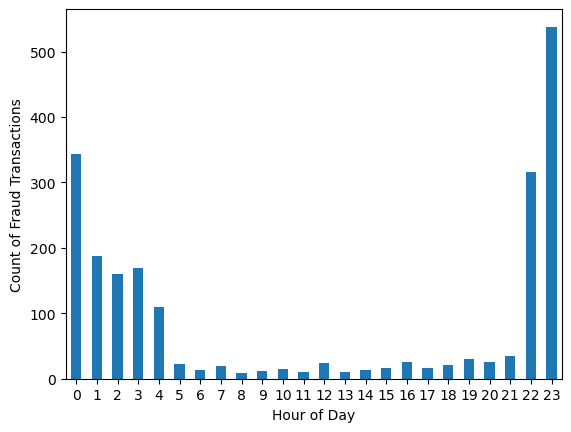

In [74]:
# observe the total number of fraudulent transactions by hour of the day
ax = df.groupby('hour_of_day').is_fraud.sum().plot(kind = 'bar', rot = 0)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Count of Fraud Transactions');

We can see above how the majority of fraudulent transactions occured in the middle of the night between 10pm and 4am. We will use this information in our model by classifying orders as taking place either in the night [22-0] (labelled 2), early morning [1-4] (labelled 1), or daytime [5-21] (labelled 0).  

In [77]:
# map function
def timegroup(hour):
    if hour in [1,2,3,4]:
        return 1
    elif hour in [0,22,23]:
        return 2    
    else:
        return 0

In [79]:
df['time_group'] = df['hour_of_day'].apply(timegroup)

In [80]:
# look at data
df.iloc[400000:400002]

,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,day,trans_dayOfWeek,hour_of_day,month_fraud_likelihood,time_group
400000,Thompson-Gleason,health_fitness,41.77,0,144 Martinez Curve,Central,IN,47110,38.0970,-86.1723,350,Counsellor,38.541852,-86.985474,0,65,24,Tuesday,23,0.004048,2
400001,"Metz, Russel and Metz",kids_pets,83.20,1,969 Huerta Path Apt. 270,Valentine,NE,69201,42.8062,-100.6215,4005,Network engineer,42.983381,-100.167981,0,75,24,Tuesday,23,0.004048,2


In [81]:
df.loc[df['time_group']==1].head(2)

,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,day,trans_dayOfWeek,hour_of_day,month_fraud_likelihood,time_group
2074,"Eichmann, Bogan and Rodriguez",gas_transport,50.3,0,4970 Michelle Burgs,Brooklyn,NY,11217,40.6816,-73.9798,2504700,Medical sales representative,41.483531,-73.520897,0,21,22,Monday,1,0.004425,1
2075,Weber and Sons,food_dining,151.1,1,923 Jordan Road,Afton,MN,55001,44.8696,-92.8234,2916,Barrister's clerk,45.000289,-93.132784,0,85,22,Monday,1,0.004425,1


In [83]:
df = df.drop(['hour_of_day'], axis=1)

In [87]:
df.columns

Index(['merchant', 'category', 'amt', 'is_male', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long',
       'is_fraud', 'cardholder_age', 'day', 'trans_dayOfWeek',
       'month_fraud_likelihood', 'time_group'],
      dtype='object')

#### Day of the Week

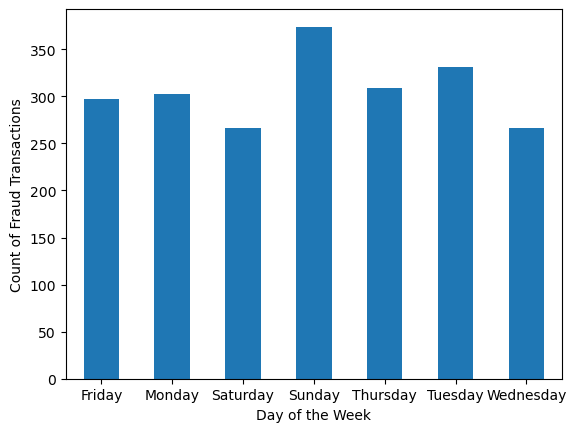

In [91]:
# observe the total number of fraudulent transactions by day of the week
ax = df.groupby('trans_dayOfWeek').is_fraud.sum().plot(kind = 'bar', rot = 0)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Count of Fraud Transactions');

We can observe no significant difference between the amount of fraud occuring on different days of the week.

#### Day of Month

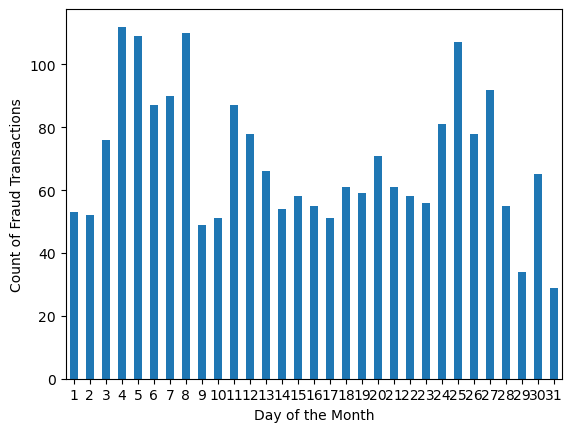

In [95]:
# observe the total number of fraudulent transactions by day of the week
ax = df.groupby('day').is_fraud.sum().plot(kind = 'bar', rot = 0)
ax.set_xlabel('Day of the Month')
ax.set_ylabel('Count of Fraud Transactions');

We can observe no significant difference between the amount of fraud occuring on different days of the month.

In [97]:
df = df.drop(['trans_dayOfWeek', 'day'], axis=1)

## Transaction Location Information

#### State

Q: Is there a correlation between the population of the state and the amount of fraudulent transactions originating there?

In [105]:
# group data by state and city
state_df_1 = pd.DataFrame(df.groupby(['state', 'city']).city_pop.mean())
state_df_1.head()

city_pop
state city                 
AK    Craig          1920.0
      Huslia          277.0
      Wales           145.0
AL    Bay Minette   19090.0
      Bessemer      71463.0

In [107]:
# find the population of each state
state_pop_df = pd.DataFrame({'state':[], 'pop':[]})
for state in df['state'].unique():
    state_pop = state_df_1.loc[state].city_pop.sum()
    info = [state, state_pop]
    state_pop_df.loc[len(state_pop_df.index)] = info

In [109]:
state_pop_df.head()

,state,pop
0,SC,506278.0
1,UT,68823.0
2,NY,6003688.0
3,FL,3593018.0
4,MI,1299880.0


In [111]:
state_df = pd.DataFrame({'state':df.groupby('state').is_fraud.sum().index,
                         'num_fraud_transactions':df.groupby('state').is_fraud.sum().values,
                         'num_total_transactions':df.groupby('state').is_fraud.count().values}
                       )

In [112]:
state_df.head()

,state,num_fraud_transactions,num_total_transactions
0,AK,14,843
1,AL,63,17532
2,AR,34,13484
3,AZ,27,4592
4,CA,76,24135


In [115]:
# combine the state information into one dataframe
state_df = pd.merge(left = state_df,
                    right = state_pop_df,
                    how = 'inner',
                    on = 'state')
state_df = state_df.set_index('state')
state_df.head(2)

,num_fraud_transactions,num_total_transactions,pop
state,,,
AK,14,843,2342.0
AL,63,17532,1476502.0


In [117]:
# add a column for percentage of transactions fraud
state_df['percent_fraud'] = state_df['num_fraud_transactions'] / state_df['num_total_transactions']

In [119]:
state_df.head(2)

,num_fraud_transactions,num_total_transactions,pop,percent_fraud
state,,,,
AK,14,843,2342.0,0.016607
AL,63,17532,1476502.0,0.003593


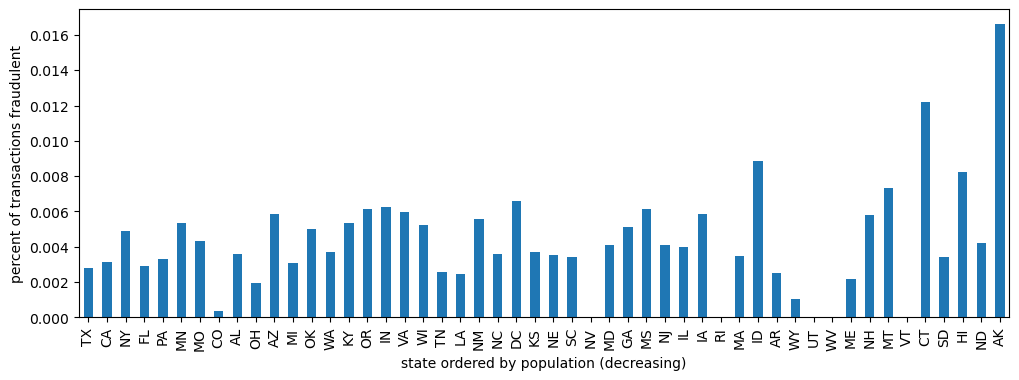

In [121]:
# plot
ax = state_df.sort_values(by='pop', ascending=False)['percent_fraud'].plot(kind='bar', rot=90, figsize=(12, 4))
ax.set_xlabel('state ordered by population (decreasing)')
ax.set_ylabel('percent of transactions fraudulent');

Observe how there is a general negative correlation between state population and fraud likelihood. Therefore, this information should be included in our model. 

In [123]:
df = pd.merge(df,state_df['pop'], how='left', on='state')
df.rename(columns={'pop': 'state_pop'}, inplace=True)
df.head()

,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,month_fraud_likelihood,time_group,state_pop
0,Kirlin and Sons,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,52,0.004425,0,506278.0
1,Sporer-Keebler,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,30,0.004425,0,68823.0
2,"Swaniawski, Nitzsche and Welch",health_fitness,41.28,0,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",40.495810,-74.196111,0,50,0.004425,0,6003688.0
3,Haley Group,misc_pos,60.05,1,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,28.812398,-80.883061,0,33,0.004425,0,3593018.0
4,Johnston-Casper,travel,3.19,1,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,44.959148,-85.884734,0,65,0.004425,0,1299880.0


In [124]:
df.columns

Index(['merchant', 'category', 'amt', 'is_male', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long',
       'is_fraud', 'cardholder_age', 'month_fraud_likelihood', 'time_group',
       'state_pop'],
      dtype='object')

#### City

Q: Is the city population variable correlated with fraudulent transactions? As city population increases, do we see an increase in total fraud?

In [129]:
df['city_state'] = df['city'] + '_' + df['state']

In [132]:
df.tail()

,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,month_fraud_likelihood,time_group,state_pop,city_state
555714,Reilly and Sons,health_fitness,43.77,1,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,39.946837,-91.333331,0,54,0.001849,2,1768032.0,Luray_MO
555715,Hoppe-Parisian,kids_pets,111.84,1,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,29.661049,-96.186633,0,21,0.001849,2,8157650.0,Lake Jackson_TX
555716,Rau-Robel,kids_pets,86.88,0,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,46.658340,-119.715054,0,39,0.001849,2,1209549.0,Burbank_WA
555717,Breitenberg LLC,travel,7.99,1,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,44.470525,-117.080888,0,55,0.001849,2,92550.0,Mesa_ID
555718,Dare-Marvin,entertainment,38.13,1,830 Myers Plaza Apt. 384,Edmond,OK,73034,35.6665,-97.4798,116001,Media buyer,36.210097,-97.036372,0,27,0.001849,2,1265206.0,Edmond_OK


In [133]:
city_df = pd.DataFrame({'city_state':df.groupby('city_state').is_fraud.sum().index,
                         'num_fraud_transactions':df.groupby('city_state').is_fraud.sum().values,
                         'num_total_transactions':df.groupby('city_state').is_fraud.count().values}
                       )

In [134]:
city_df.head()

,city_state,num_fraud_transactions,num_total_transactions
0,Achille_OK,0,208
1,Acworth_NH,0,828
2,Adams_WI,12,223
3,Afton_MI,7,436
4,Afton_MN,0,461


In [135]:
city_df_1 = state_df_1.reset_index()

In [137]:
city_df_1.head(2)

,state,city,city_pop
0,AK,Craig,1920.0
1,AK,Huslia,277.0


In [139]:
city_df_1['city_state'] = city_df_1['city'] + '_' + city_df_1['state']

In [141]:
city_df_1.head(2)

,state,city,city_pop,city_state
0,AK,Craig,1920.0,Craig_AK
1,AK,Huslia,277.0,Huslia_AK


In [144]:
city_df_1 = city_df_1.drop(['state', 'city'], axis=1)

In [147]:
city_df = pd.merge(left=city_df, right=city_df_1, how='left', on='city_state')

In [149]:
city_df.head(2)

,city_state,num_fraud_transactions,num_total_transactions,city_pop
0,Achille_OK,0,208,608.0
1,Acworth_NH,0,828,477.0


In [150]:
city_df['percent_fraud'] = city_df['num_fraud_transactions'] / city_df['num_total_transactions']

In [151]:
city_df.head(2)

,city_state,num_fraud_transactions,num_total_transactions,city_pop,percent_fraud
0,Achille_OK,0,208,608.0,0.0
1,Acworth_NH,0,828,477.0,0.0


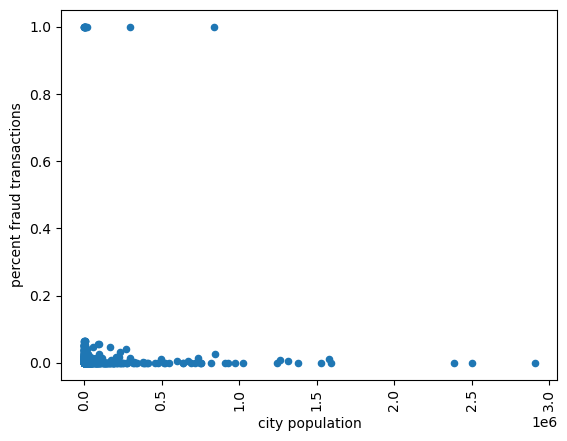

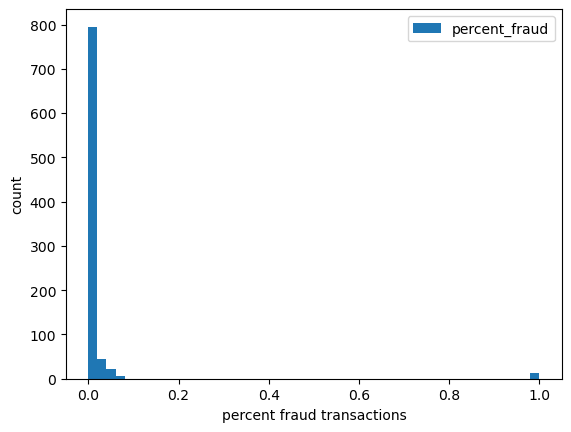

In [153]:
# plot
ax1 = city_df.plot.scatter(x='city_pop', y='percent_fraud', rot=90)
ax1.set_xlabel('city population')
ax1.set_ylabel('percent fraud transactions')

ax2 = city_df.plot.hist(column='percent_fraud', bins=50)
ax2.set_xlabel('percent fraud transactions')
ax2.set_ylabel('count');

We can observe above that a few cities had 100 percent of their transactions fraudulent. This plot clearly delineates two groups that we can classify the cities into: high and low risk. It is important to keep in mind that this data is simulated. 

In [160]:
city_df['city_risk'] = city_df['percent_fraud'].apply(lambda x: 1 if x==1 else 0)

In [161]:
city_df.head(2)

,city_state,num_fraud_transactions,num_total_transactions,city_pop,percent_fraud,city_risk
0,Achille_OK,0,208,608.0,0.0,0
1,Acworth_NH,0,828,477.0,0.0,0


In [162]:
df = pd.merge(df,city_df[['city_state','city_risk']], how='left', on='city_state')

In [163]:
df.head(2)

,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,month_fraud_likelihood,time_group,state_pop,city_state,city_risk
0,Kirlin and Sons,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,52,0.004425,0,506278.0,Columbia_SC,0
1,Sporer-Keebler,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,30,0.004425,0,68823.0,Altonah_UT,0


In [164]:
df.columns

Index(['merchant', 'category', 'amt', 'is_male', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long',
       'is_fraud', 'cardholder_age', 'month_fraud_likelihood', 'time_group',
       'state_pop', 'city_state', 'city_risk'],
      dtype='object')

In [319]:
df = df.drop(['street','city', 'state', 'zip', 'city_state'], axis=1)

#### Distance Between Transaction and Merchant

In [175]:
# add a euclidean distance column 
# difference in latitude between cardholder and merchant
df['lat_diff'] = np.abs(df['lat'] - df['merch_lat'])

# difference in logitude between cardholder and merchant
df['long_diff'] = np.abs(df['long'] - df['merch_long'])

# compute the manhattan distance between cardholder and merchant
df['dist'] = np.sqrt(df['lat_diff']**2 + df['long_diff']**2)


# remove the lat and long differnece variables 
df = df.drop(['lat_diff', 'long_diff'], axis=1)

In [176]:
df.head(2)

,merchant,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,month_fraud_likelihood,time_group,state_pop,city_state,city_risk,dist
0,Kirlin and Sons,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,52,0.004425,0,506278.0,Columbia_SC,0,0.266004
1,Sporer-Keebler,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,30,0.004425,0,68823.0,Altonah_UT,0,0.991674


In [179]:
df.dist.max()

1.4122207886166418

In [181]:
df.dist.min()

0.0014289636104533178

In [183]:
np.linspace(df.dist.min(), df.dist.max(), 50)

array([0.00142896, 0.03022063, 0.0590123 , 0.08780397, 0.11659564,
       0.14538731, 0.17417898, 0.20297065, 0.23176232, 0.26055399,
       0.28934566, 0.31813733, 0.346929  , 0.37572067, 0.40451234,
       0.43330401, 0.46209568, 0.49088735, 0.51967902, 0.54847069,
       0.57726236, 0.60605403, 0.6348457 , 0.66363737, 0.69242904,
       0.72122071, 0.75001238, 0.77880405, 0.80759572, 0.83638739,
       0.86517906, 0.89397073, 0.9227624 , 0.95155407, 0.98034574,
       1.00913741, 1.03792908, 1.06672075, 1.09551242, 1.12430409,
       1.15309576, 1.18188743, 1.2106791 , 1.23947077, 1.26826244,
       1.29705411, 1.32584578, 1.35463745, 1.38342912, 1.41222079])

In [185]:
l = np.linspace(df.dist.min(), df.dist.max(), 50)

In [187]:
bucket = []
f_likelihoods = []

In [189]:
for i in range(1,50):
    bottom = l[i-1]
    top = l[i]
    new = df.loc[(df['dist'] >= bottom) &  (df['dist'] < top)] # filtering data to transactions within a distance range 
    fraud_sum = new.is_fraud.sum() # counting the number of fraudulent transactions
    count_transactions = new.shape[0] # counting the number of total transactions
    fraud_likelihood = fraud_sum/count_transactions # fraudulent transactions / total transactions
    bucket.append(top)
    f_likelihoods.append(fraud_likelihood)

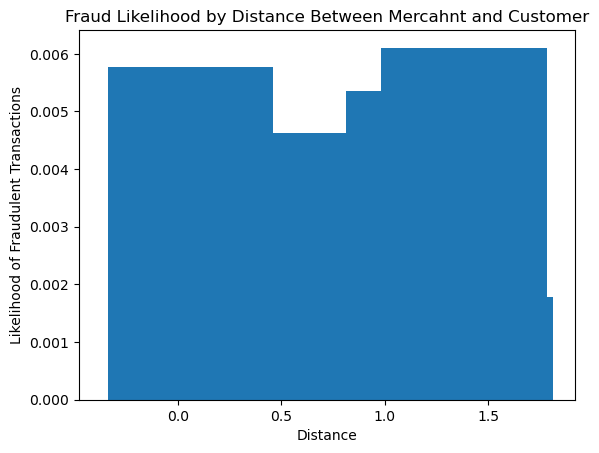

In [190]:
# plot
plt.bar(bucket, f_likelihoods)
plt.xlabel("Distance")  
plt.ylabel("Likelihood of Fraudulent Transactions")  
plt.title("Fraud Likelihood by Distance Between Mercahnt and Customer")
plt.show()

Above we can see that the distance between the merchant and the customer does not provide useful information in predicting whether the transaction was fraudulent.

In [194]:
df = df.drop(['dist'], axis=1)

### Merchant Information

#### Merchant Feature Engineering

In [200]:
# Find how many of the transactions that occured at the merchants were fraudulent transactions and print the top five.

merch_df = pd.DataFrame({'merchant':df.groupby('merchant').is_fraud.sum().index,
                         'num_fraud_transactions':df.groupby('merchant').is_fraud.sum().values,
                         'num_total_transactions':df.groupby('merchant').is_fraud.count().values},
                       )

In [201]:
merch_df.head()

,merchant,num_fraud_transactions,num_total_transactions
0,Abbott-Rogahn,1,803
1,Abbott-Steuber,2,766
2,Abernathy and Sons,0,762
3,Abshire PLC,0,838
4,"Adams, Kovacek and Kuhlman",1,414


In [203]:
merch_df['fraud_raw_prob'] = (merch_df['num_fraud_transactions'] / merch_df['num_total_transactions'])
merch_df.sort_values(by='fraud_raw_prob', ascending=False).head()

,merchant,num_fraud_transactions,num_total_transactions,fraud_raw_prob
528,"Romaguera, Cruickshank and Greenholt",18,828,0.021739
386,Lemke-Gutmann,18,837,0.021505
443,"Mosciski, Ziemann and Farrell",18,870,0.020690
238,"Heathcote, Yost and Kertzmann",17,830,0.020482
523,"Rodriguez, Yost and Jenkins",10,501,0.019960


In [208]:
# add more columns
merch_df['merch_lat'] = df.groupby('merchant').merch_lat.mean().values
merch_df['merch_long'] = df.groupby('merchant').merch_long.mean().values
merch_df['avg_amt'] = df.groupby('merchant').amt.mean().values
merch_df['tot_amt'] = df.groupby('merchant').amt.sum().values
merch_df['male_customer_avg'] = df.groupby('merchant').is_male.mean().values

# set index to merchant name
merch_df = merch_df.set_index('merchant')
merch_df.head()

,num_fraud_transactions,num_total_transactions,fraud_raw_prob,merch_lat,merch_long,avg_amt,tot_amt,male_customer_avg
merchant,,,,,,,,
Abbott-Rogahn,1,803,0.001245,38.671303,-90.644001,66.198369,53157.29,0.474471
Abbott-Steuber,2,766,0.002611,38.327988,-89.925832,51.221958,39236.02,0.408616
Abernathy and Sons,0,762,0.000000,38.459248,-90.215522,50.650630,38595.78,0.442257
Abshire PLC,0,838,0.000000,38.591720,-90.183716,62.932876,52737.75,0.494033
"Adams, Kovacek and Kuhlman",1,414,0.002415,38.831748,-90.206514,54.640507,22621.17,0.403382


#### Find merchant clusters

In [211]:
# feature scaling
# this is important because K-means uses euclidean distance 
from sklearn.preprocessing import StandardScaler

In [213]:
# standardization
s_scaler = StandardScaler()
s_scaled = s_scaler.fit_transform(merch_df)
s_scaled_df = pd.DataFrame(s_scaled, columns=merch_df.columns)

In [214]:
s_scaled_df.head(2)

,num_fraud_transactions,num_total_transactions,fraud_raw_prob,merch_lat,merch_long,avg_amt,tot_amt,male_customer_avg
0,-0.581479,0.004468,-0.604492,0.579569,-0.813110,-0.166877,-0.100038,0.642687
1,-0.303955,-0.146276,-0.280780,-0.825588,0.564054,-0.837672,-0.659556,-1.301741


In [215]:
# decide on a number of clusters to make
# cluster inertia within-cluster sum of squares mean

from sklearn.cluster import KMeans

wcss = [] 
for i in range(1,11):
    model = KMeans(n_clusters=i, random_state=2001)
    y_kmeans = model.fit_predict(s_scaled_df)
    wcss.append(model.inertia_)  # record inter-cluster inertia

In [216]:
import matplotlib.pyplot as plt

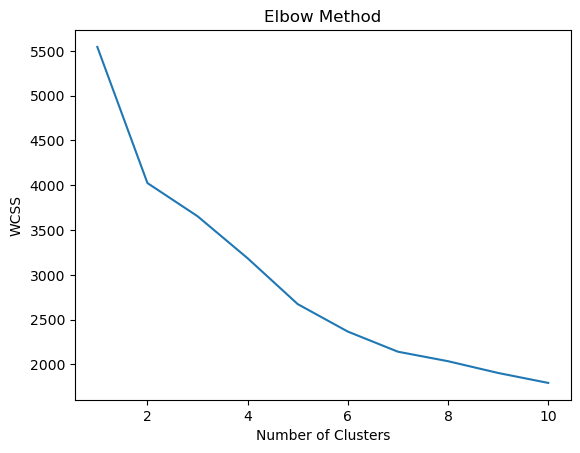

In [217]:
plt.plot(range(1,11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

From the above method - will choose to make 5 merchant clusters.

In [219]:
# assign clusters to merchants
model = KMeans(n_clusters=5, random_state=2001)
y_kmeans = model.fit_predict(s_scaled_df)
merch_df['merch_cluster'] = y_kmeans
merch_df.head()

,num_fraud_transactions,num_total_transactions,fraud_raw_prob,merch_lat,merch_long,avg_amt,tot_amt,male_customer_avg,merch_cluster
merchant,,,,,,,,,
Abbott-Rogahn,1,803,0.001245,38.671303,-90.644001,66.198369,53157.29,0.474471,0
Abbott-Steuber,2,766,0.002611,38.327988,-89.925832,51.221958,39236.02,0.408616,3
Abernathy and Sons,0,762,0.000000,38.459248,-90.215522,50.650630,38595.78,0.442257,3
Abshire PLC,0,838,0.000000,38.591720,-90.183716,62.932876,52737.75,0.494033,0
"Adams, Kovacek and Kuhlman",1,414,0.002415,38.831748,-90.206514,54.640507,22621.17,0.403382,3


In [223]:
# add new information to the larger df
df = pd.merge(df, merch_df[['fraud_raw_prob','merch_cluster']], how='left', on='merchant')

# rename column
df.rename(columns={'fraud_raw_prob': 'merchant_fraud_likelihood'}, inplace=True)

# remove merchant name
df = df.drop(['merchant'], axis=1)

In [225]:
df.head(5)

,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,month_fraud_likelihood,time_group,state_pop,city_state,city_risk,merchant_fraud_likelihood,merch_cluster
0,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,52,0.004425,0,506278.0,Columbia_SC,0,0.004076,3
1,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,30,0.004425,0,68823.0,Altonah_UT,0,0.001274,3
2,health_fitness,41.28,0,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",40.495810,-74.196111,0,50,0.004425,0,6003688.0,Bellmore_NY,0,0.001325,0
3,misc_pos,60.05,1,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,28.812398,-80.883061,0,33,0.004425,0,3593018.0,Titusville_FL,0,0.004219,3
4,travel,3.19,1,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,44.959148,-85.884734,0,65,0.004425,0,1299880.0,Falmouth_MI,0,0.002703,4


### Job Information Analysis
- create job clusters since too many unique jobs for OHE 

In [234]:
df.head(2)

,category,amt,is_male,street,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,cardholder_age,month_fraud_likelihood,time_group,state_pop,city_state,city_risk,merchant_fraud_likelihood,merch_cluster
0,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,33.986391,-81.200714,0,52,0.004425,0,506278.0,Columbia_SC,0,0.004076,3
1,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",39.450498,-109.960431,0,30,0.004425,0,68823.0,Altonah_UT,0,0.001274,3


In [236]:
len(df.job.unique()) # 478 unique jobs

478

In [238]:
job_df = pd.DataFrame({'job':df.groupby('job').is_fraud.sum().index,
                         'num_fraud_transactions':df.groupby('job').is_fraud.sum().values,
                         'num_total_transactions':df.groupby('job').is_fraud.count().values},
                       )

In [239]:
job_df['fraud_likelihood'] = job_df['num_fraud_transactions'] / job_df['num_total_transactions']

In [242]:
sorted_jobs = job_df.sort_values(by='fraud_likelihood', ascending = False)

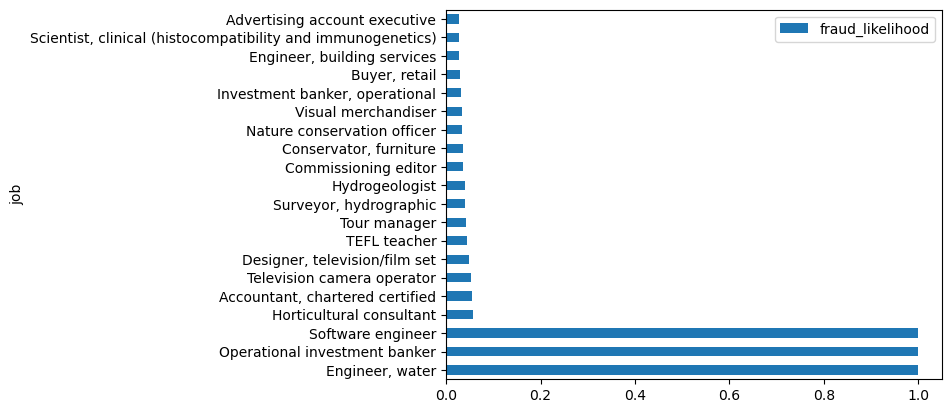

In [244]:
# plot the fraud likelihood for the 20 mot fraudulent jobs types
sorted_jobs[sorted_jobs['fraud_likelihood']>0].head(20).plot.barh(x='job', y='fraud_likelihood');

In [245]:
job_df

,job,num_fraud_transactions,num_total_transactions,fraud_likelihood
0,Academic librarian,0,426,0.000000
1,"Accountant, chartered certified",12,217,0.055300
2,"Accountant, chartered public finance",0,1077,0.000000
3,Accounting technician,0,1922,0.000000
4,Acupuncturist,0,621,0.000000
...,...,...,...,...
473,Water engineer,13,2576,0.005047
474,Water quality scientist,0,224,0.000000
475,Web designer,0,1106,0.000000
476,Wellsite geologist,12,1068,0.011236


Can see above that some jobs have a higher likelihood of fraudulent transactions than others. Therefore we should add this information to our model.

In [249]:
# add new information to the larger df
df = pd.merge(df, job_df[['job','fraud_likelihood']], how='left', on='job')

# rename column
df.rename(columns={'fraud_likelihood': 'job_fraud_likelihood'}, inplace=True)

# remove job title
df = df.drop(['job'], axis=1)

In [251]:
df.head(2)

,category,amt,is_male,street,city,state,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,cardholder_age,month_fraud_likelihood,time_group,state_pop,city_state,city_risk,merchant_fraud_likelihood,merch_cluster,job_fraud_likelihood
0,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,33.986391,-81.200714,0,52,0.004425,0,506278.0,Columbia_SC,0,0.004076,3,0.0
1,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,39.450498,-109.960431,0,30,0.004425,0,68823.0,Altonah_UT,0,0.001274,3,0.0


### Product Category Analysis

In [257]:
# create a pie plot for percent of fraudulent transactions for each category

In [259]:
cat_df = pd.DataFrame({'category':df.groupby('category').is_fraud.sum().index,
                         'num_fraud_transactions':df.groupby('category').is_fraud.sum().values,
                         'num_total_transactions':df.groupby('category').is_fraud.count().values}
                       )

In [260]:
cat_df['percent_fraud'] = cat_df['num_fraud_transactions'] / cat_df['num_total_transactions']

In [263]:
cat_df['percent_fraud'].sum()

0.05325076882566513

In [265]:
cat_df.head(2)

,category,num_fraud_transactions,num_total_transactions,percent_fraud
0,entertainment,59,40104,0.001471
1,food_dining,54,39268,0.001375


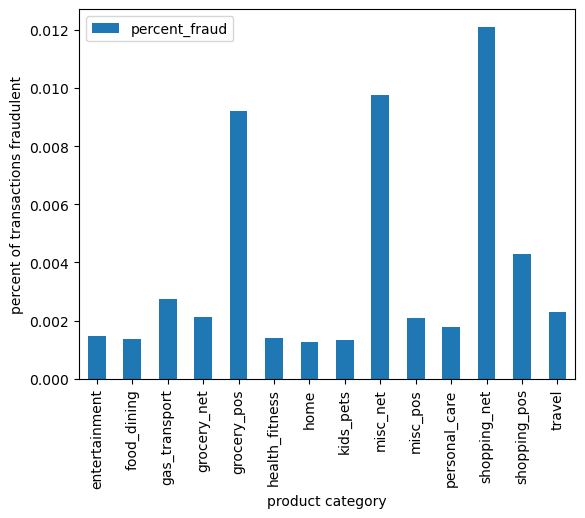

In [267]:
# plot
ax = cat_df.plot.bar(x='category', y='percent_fraud')
ax.set_xlabel('product category')
ax.set_ylabel('percent of transactions fraudulent');

Can see above that the categories with the largest likelihoods of fraud are grocery_pos, misc_net, and shopping_net. We will group the categories into two groups along these lines. 

In [269]:
cat_df['cat_risk'] = cat_df['percent_fraud'].apply(lambda x: 1 if x>.006 else 0)

In [271]:
cat_df

,category,num_fraud_transactions,num_total_transactions,percent_fraud,cat_risk
0,entertainment,59,40104,0.001471,0
1,food_dining,54,39268,0.001375,0
2,gas_transport,154,56370,0.002732,0
3,grocery_net,41,19426,0.002111,0
4,grocery_pos,485,52553,0.009229,1
5,health_fitness,52,36674,0.001418,0
6,home,67,52345,0.001280,0
7,kids_pets,65,48692,0.001335,0
8,misc_net,267,27367,0.009756,1
9,misc_pos,72,34574,0.002082,0


In [274]:
df = pd.merge(df, cat_df[['category','cat_risk']], how='left', on='category')

In [275]:
df.head()

,category,amt,is_male,street,city,state,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,cardholder_age,month_fraud_likelihood,time_group,state_pop,city_state,city_risk,merchant_fraud_likelihood,merch_cluster,job_fraud_likelihood,cat_risk
0,personal_care,2.86,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,33.986391,-81.200714,0,52,0.004425,0,506278.0,Columbia_SC,0,0.004076,3,0.000000,0
1,personal_care,29.84,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,39.450498,-109.960431,0,30,0.004425,0,68823.0,Altonah_UT,0,0.001274,3,0.000000,0
2,health_fitness,41.28,0,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,40.495810,-74.196111,0,50,0.004425,0,6003688.0,Bellmore_NY,0,0.001325,0,0.005798,0
3,misc_pos,60.05,1,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,28.812398,-80.883061,0,33,0.004425,0,3593018.0,Titusville_FL,0,0.004219,3,0.015083,0
4,travel,3.19,1,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,44.959148,-85.884734,0,65,0.004425,0,1299880.0,Falmouth_MI,0,0.002703,4,0.000000,0


In [277]:
# remove category 
df = df.drop(['category'], axis=1)

#### Product Category One Hot Encoding
Uncommenting the following code would be an alternative way to make use of the "category" feature in the model.

In [282]:
# print('list of unique product categories: ')
# print(list(df.category.unique()))
# print()
# print(len(list(df.category.unique())), 'unique product categories')

In [284]:
# # oneHot encode the product category feature
# df = pd.get_dummies(df, columns=['category'], dtype=int)

In [286]:
# df.head()

In [288]:
# df.info()

## Modeling

In [321]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

In [323]:
y = df['is_fraud']
X = df.drop(['is_fraud'], axis=1)

In [325]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2001)
print( f"shape of X_train, y_train, X_test, y_test: {X_train.shape}, {y_train.shape},{X_test.shape},{y_test.shape}")

shape of X_train, y_train, X_test, y_test: (389003, 16), (389003,),(166716, 16),(166716,)


In [327]:
# check the rate of fraud
sum(y_train)/len(y_train)

0.0038508700447040254

In [329]:
# if you predicted NOT fraud for every transaction your accuracy would be ...
y_train[y_train==0].size / y_train.size

0.9961491299552959

In [331]:
# therefore we need a model to be more accurate than this

### Decision Tree

In [335]:
# Create a Decision Tree using entropy as attribute selection
DT_clf = tree.DecisionTreeClassifier(criterion = 'entropy')

In [337]:
# Training the tree
DT_clf = DT_clf.fit(X_train, y_train)

In [339]:
# class probabilities
probabs = (DT_clf.predict_proba(X_test))

In [341]:
# generate predictions
y_pred = (probabs[:,1] >= 0.01).astype(bool)

In [343]:
# more accurate than always predicting NOT fraud?
print('Decision Tree Accuracy:', sum(y_pred == y_test)/len(y_pred))
(sum(y_pred == y_test)/len(y_pred)) > (y_train[y_train==0].size / y_train.size)

Decision Tree Accuracy: 0.9973667794332878


True

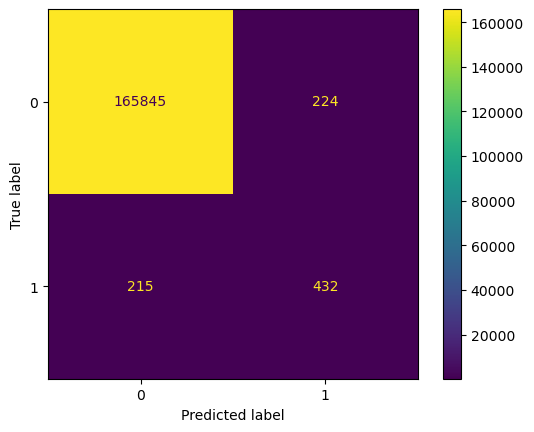

In [345]:
c_mat = confusion_matrix(y_test, y_pred, labels=DT_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=DT_clf.classes_)
disp.plot();

In [347]:
F1_score = f1_score(y_test, y_pred)
precision = c_mat[0,0] / (c_mat[0,0]+c_mat[1,0])
recall = c_mat[0,0] / (c_mat[0,0]+c_mat[0,1])

print('DT F1 Score:', F1_score)
print('DT Precision:', precision)
print('DT Recall:', recall)

DT F1 Score: 0.6630851880276285
DT Precision: 0.9987052872455738
DT Recall: 0.9986511630707718


### Logistic Regression

In [352]:
# Creating and training the model
LR_clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [353]:
# class probabilities
probabs = (LR_clf.predict_proba(X_test))

In [354]:
# choosing an optimal threshold

In [358]:
import matplotlib.pyplot as plt
import numpy as np

In [360]:
t_list = np.linspace(0.1, 0.005, 100)
f1_list = []

for threshold in t_list:
    y_pred = (probabs[:,1] >= threshold).astype(bool)
    f1_list.append(f1_score(y_test, y_pred))

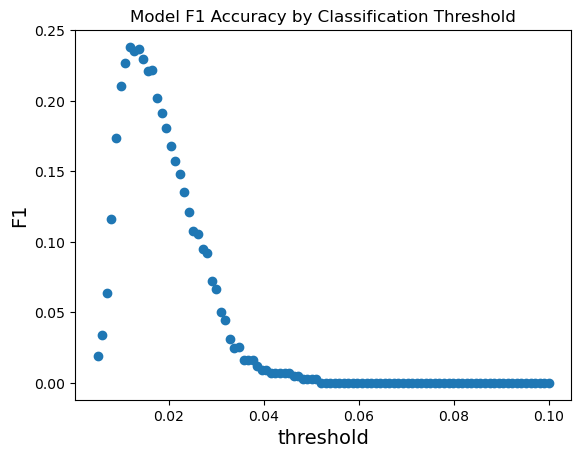

In [361]:
plt.title('Model F1 Accuracy by Classification Threshold')
plt.xlabel('threshold', size = 14)
plt.ylabel('F1', size = 14)
plt.scatter(t_list,f1_list);

In [364]:
# Find the threshold corresponding to the largest F1 score
max_value = max(f1_list)
max_index = f1_list.index(max_value)
print('Optimal Threshold:', t_list[max_index])

Optimal Threshold: 0.011717171717171723


In [366]:
# generate predictions
y_pred = (probabs[:,1] >= 0.011717).astype(bool)

In [368]:
# more accurate than always predicting NOT fraud?
print('Logistic Reg. Accuracy:', sum(y_pred == y_test)/len(y_pred))
(sum(y_pred == y_test)/len(y_pred)) > (y_train[y_train==0].size / y_train.size)

Logistic Reg. Accuracy: 0.9921783152186953


False

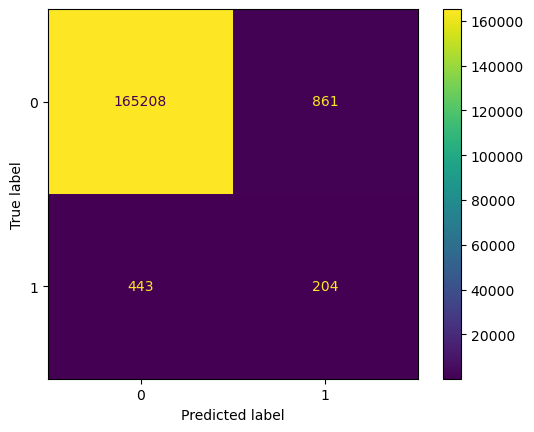

In [370]:
c_mat = confusion_matrix(y_test, y_pred, labels=LR_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=c_mat, display_labels=LR_clf.classes_)
disp.plot();

In [372]:
F1_score = f1_score(y_test, y_pred)
precision = c_mat[0,0] / (c_mat[0,0]+c_mat[1,0])
recall = c_mat[0,0] / (c_mat[0,0]+c_mat[0,1])

print('LR F1 Score:', F1_score)
print('LR Precision:', precision)
print('LR Recall:', recall)

LR F1 Score: 0.2383177570093458
LR Precision: 0.9973257028330647
LR Recall: 0.9948154080532791


### Comparison
In the context of predicting credit fraud, the most important metric to consider is F1 Score. We want our model to have high sensitivity, because we want to make sure we catch any fraudulent behavior as it can result in losses of cardholders. However, we are also interested in a high specificity, or a small number of false positives. This is because it can be a real detriment to a cardholder to not be able to use their card if they need it in some situation, i.e. by classifying a non-fraudulent transaction as fraudulent, the cardholder might be denied access to their funds for no good reason. F1-score takes both of these into account. Therefore, in this context, the Decision Tree model performs the best. 

### Future Work
Figure out how to boost the accuracy of the Logistic Regression model. 
- check for collinearity in the predictor variables
- apply standardization to the training data
- try other models as seen below

#### KNN

In [448]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [449]:
predictions = neigh.predict(X_test)

In [450]:
#print(predictions)
acc = np.sum(predictions == y_test) / len(y_test)
print('KNN accuracy:', acc)

KNN accuracy: 0.996305093692267


In [451]:
c_mat = confusion_matrix(y_test, predictions)
c_mat

array([[165729,    340],
       [   276,    371]])

In [452]:
F1_score = f1_score(y_test, predictions)
precision = c_mat[0,0] / (c_mat[0,0]+c_mat[1,0])
recall = c_mat[0,0] / (c_mat[0,0]+c_mat[0,1])

print('KNN F1 Score:', F1_score)
print('KNN Precision:', precision)
print('KNN Recall:', recall)

KNN F1 Score: 0.5463917525773195
KNN Precision: 0.9983373994759194
KNN Recall: 0.9979526582324214


#### SVM

In [136]:
svm_clf = svm.SVC(kernel='linear').fit(X_train,y_train)

In [137]:
predictions = svm_clf.predict(X_test)

In [138]:
acc = np.sum(predictions == y_test) / len(y_test)
print('SVM accuracy:', acc)

SVM accuracy: 0.9946666666666667


In [139]:
c_mat = confusion_matrix(y_test, predictions)
c_mat

array([[2984,   10],
       [   6,    0]])

In [141]:
F1_score = f1_score(y_test, predictions)
precision = c_mat[0,0] / (c_mat[0,0]+c_mat[1,0])
recall = c_mat[0,0] / (c_mat[0,0]+c_mat[0,1])

print('SVM F1 Score:', F1_score)
print('SVM Precision:', precision)
print('SVM Recall:', recall)

SVM F1 Score: 0.0
SVM Precision: 0.9979933110367893
SVM Recall: 0.9966599866399466


#### Adaptive Boosting

In [ ]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=0)

# Train Adaboost Classifer
model1 = abc.fit(X_train, y_train)


#Predict the response for test dataset
y_pred = model1.predict(X_test)